# Project 6: Time Series Analysis & Forecasting 📈

**Project Objective:** To build a time series model to forecast the number of airline passengers for future months. This project provides a comprehensive, step-by-step guide to time series analysis, from data decomposition and stationarity testing to building and evaluating ARIMA and SARIMA models.

### Core Concepts We'll Cover:
1.  **Time Series Fundamentals:** Understanding the components of a time series (Trend, Seasonality, Residuals).
2.  **Stationarity:** Learning what stationarity is, why it's crucial for many models, and how to test for it (Augmented Dickey-Fuller test).
3.  **Data Transformation:** Applying techniques like differencing and log transforms to make a series stationary.
4.  **Model Identification:** Using Autocorrelation (ACF) and Partial Autocorrelation (PACF) plots to determine model parameters.
5.  **ARIMA Modeling:** Building a baseline ARIMA model for forecasting.
6.  **SARIMA Modeling:** Extending ARIMA to build a powerful SARIMA model that explicitly handles seasonality.
7.  **Forecasting & Evaluation:** Making predictions and evaluating model performance.

### **Theoretical Concept: What is a Time Series?**

A time series is a sequence of data points collected or recorded at specific time intervals (e.g., daily, monthly, yearly). Unlike other datasets we've worked with, the order of data points in a time series is critical.

A time series can be broken down into several components:
1.  **Trend:** The long-term upward or downward movement in the data.
2.  **Seasonality:** A repeating, predictable pattern over a fixed period (e.g., sales are higher every December).
3.  **Cyclical Component:** Patterns that occur at irregular, non-fixed intervals (e.g., business cycles). This is often harder to model and is sometimes combined with the trend.
4.  **Residuals (or Noise):** The random, irregular fluctuations that are left over after the other components have been removed.



### Step 1: Setup - Importing Libraries and Loading Data

In [1]:
pip install statsmodels

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima.model import ARIMA # Corrected import statement
from sklearn.metrics import mean_squared_error

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

In [3]:
!git clone 'https://github.com/HarshvardhanSingh-13/Datasets'

Cloning into 'Datasets'...
remote: Enumerating objects: 335, done.
remote: Counting objects: 100% (93/93), done.
remote: Compressing objects: 100% (80/80), done.
remote: Total 335 (delta 22), reused 0 (delta 0), pack-reused 242 (from 1)
Receiving objects: 100% (335/335), 302.68 MiB | 10.56 MiB/s, done.
Resolving deltas: 100% (136/136), done.
Updating files: 100% (243/243), done.


In [4]:
df = pd.read_csv('/content/Datasets/Airline Timeseries/airline_passenger_timeseries.csv')
df.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [5]:
df.shape

(144, 2)

In [6]:
df.tail()

,Month,Passengers
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390
143,1960-12,432


### Step 2: Exploratory Data Analysis & Decomposition

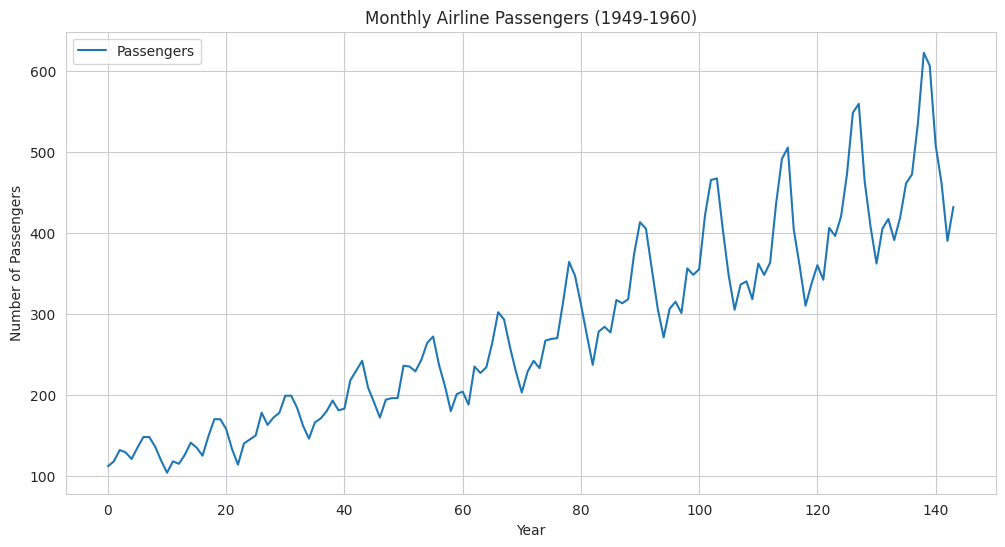

In [7]:
df.plot()
plt.title('Monthly Airline Passengers (1949-1960)')
plt.xlabel('Year')
plt.ylabel('Number of Passengers')
plt.show()

**Initial Observation:** The plot clearly shows two strong patterns:
1.  **Upward Trend:** The number of passengers is increasing over time.
2.  **Seasonality:** There is a clear, repeating annual pattern (peaks and troughs within each year).
3.  **Increasing Variance:** The seasonal fluctuations appear to be getting larger over time.

In [8]:
df.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [9]:
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)

In [10]:
df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


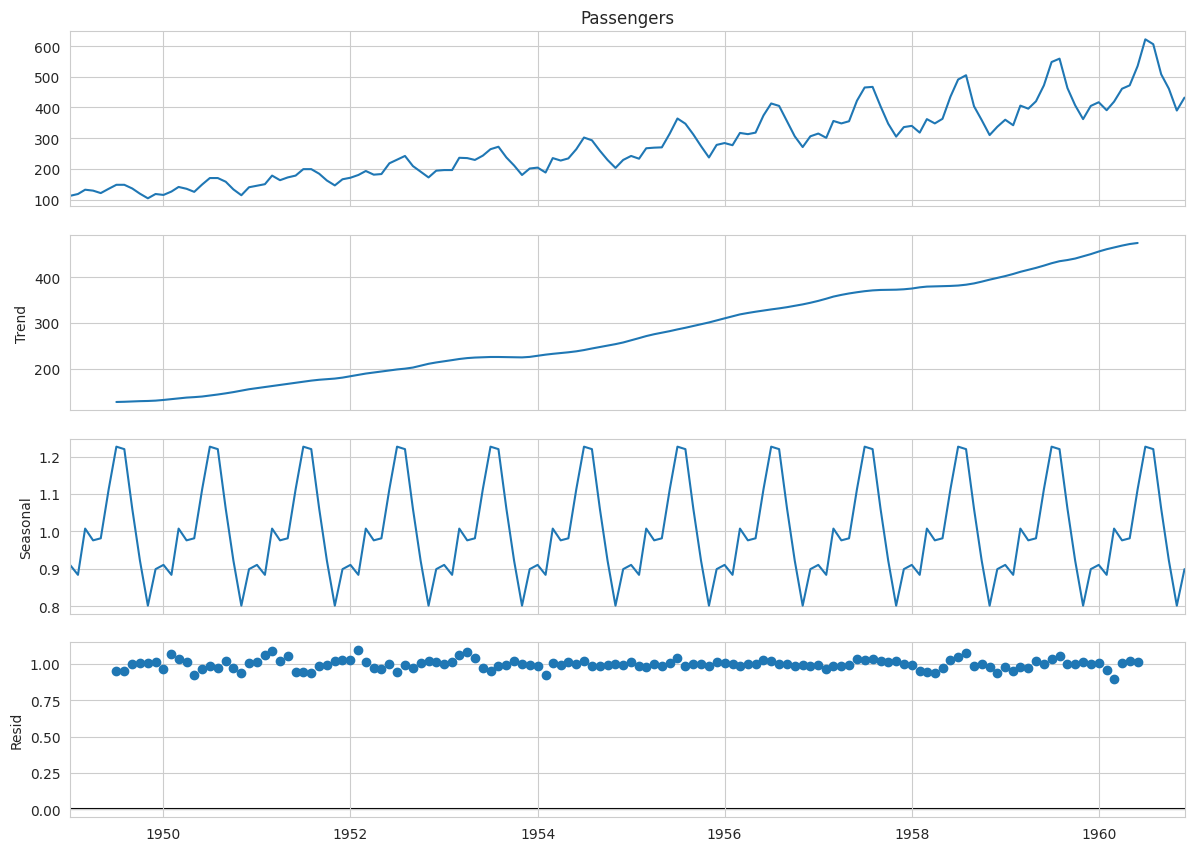

In [11]:
decomposition = sm.tsa.seasonal_decompose(df['Passengers'], model='multiplicative')

fig = decomposition.plot()
fig.set_size_inches(12,9)
plt.show()

### Step 3: Stationarity Testing
Before we can build a model like ARIMA, the time series needs to be **stationary**.

#### **Theoretical Concept: Stationarity**
A time series is said to be stationary if its statistical properties—specifically the **mean**, **variance**, and **autocorrelation**—are all constant over time.

- **Why is it important?** Stationary series are easier to model and forecast. If a series is stationary, its past behavior is a good predictor of its future behavior. Our passenger data is clearly **non-stationary** because its mean (the trend is increasing) and variance (the seasonal swings are growing) are not constant.

**How to test for it?**
1.  **Visual Inspection:** Look at the plot. Is there a clear trend or seasonality?
2.  **Statistical Tests:** The **Augmented Dickey-Fuller (ADF) Test** is a common statistical test.
    - **Null Hypothesis ($H_0$):** The series is non-stationary.
    - **Alternative Hypothesis ($H_1$):** The series is stationary.

We want to **reject the null hypothesis**. To do this, we need the **p-value** from the test to be less than a significance level (e.g., 0.05).

#### Think of the ADF test as asking the question: "Does this time series have a trend or other patterns that make it non-stationary?"

Here's what each part means:

* Test Statistic: This is a number calculated from your data. It's the main result of the test.
* p-value: This is the most important number for a beginner. It tells you how likely it is that you would get your results if the time series were actually stationary (which is the opposite of what we usually want).
* If the p-value is small (usually less than 0.05): This means it's very unlikely to get these results if the series were stationary. So, you can confidently say, "Okay, this series is not stationary."
* If the p-value is large : This means it's quite likely to get these results even if the series were stationary. So, you cannot confidently say it's not stationary. In other words, you fail to reject the null hypothesis, which is that the series is non-stationary.
###Lags Used: This is the number of past data points the test looked at to help make its decision.
* Number of Observations Used: This is how many data points from your time series were actually used in the test calculation.
* Critical Value (1%), (5%), (10%): These are threshold values. If your "Test Statistic" is smaller than one of these critical values (more negative), you would reject the null hypothesis at that confidence level. For example, if your Test Statistic was less than -3.48 (the 1% critical value), you'd be very confident (99%) that the series is stationary.
Why do we use it?

* We use the ADF test (and look at the p-value) because many powerful time series forecasting models, like ARIMA, assume that the data they are working with is stationary. If your data is not stationary, these models might not work well or give you inaccurate forecasts. The ADF test gives us a statistical way to check this assumption before we build our models.

* In your case, the high p-value (0.99) tells us that your 'Passengers' data is non-stationary, just as we suspected from looking at the plot earlier. This confirms that you need to perform transformations (like differencing) to make it stationary before building an ARIMA model.

In [12]:
def test_stationarity(timeseries):
    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

test_stationarity(df['Passengers'])

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


### Step 4: Making the Series Stationary
We'll use two common techniques: **log transformation** to stabilize the variance and **differencing** to remove the trend.

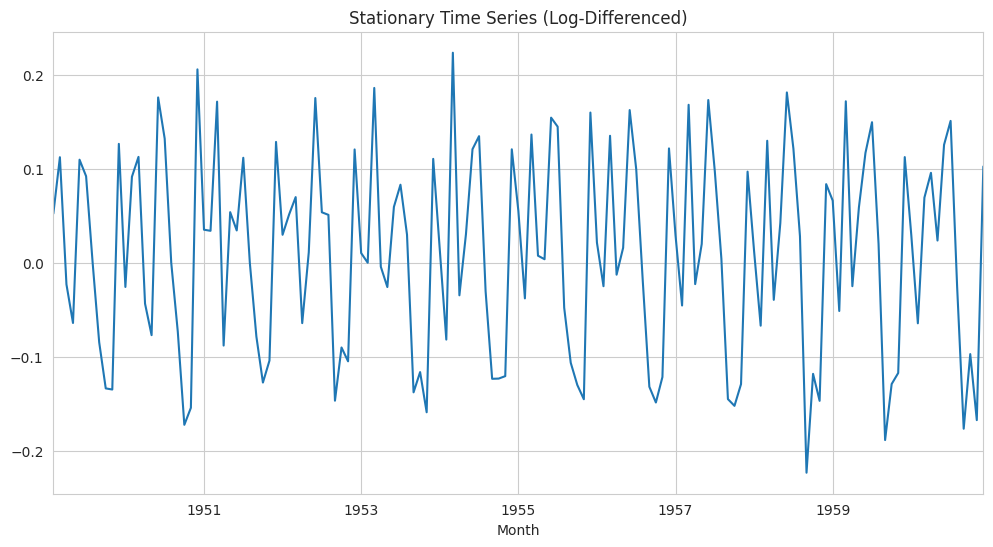

Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


In [13]:
## 1. Applying Log Transformation
df_log = np.log(df['Passengers'])

## 2. Applying Differencing to remove Trends
df_diff = df_log.diff().dropna()

## 3. Plotting the series
df_diff.plot()
plt.title('Stationary Time Series (Log-Differenced)')
plt.show()

# Retest for stationarity
test_stationarity(df_diff)

* ACF (Autocorrelation Function): Measures the correlation between a time series and its lagged versions (e.g., how much the value today is correlated with the value yesterday, the day before, etc.). The plot shows spikes at lags where there is significant autocorrelation.
* PACF (Partial Autocorrelation Function): Measures the direct correlation between a time series and its lagged versions, after removing the effects of the intermediate lags. It helps identify the direct relationship between the current value and a specific lagged value.
These plots help us determine the p and q parameters for the ARIMA model:

### Step 5: Model Identification with ACF and PACF Plots

#### **Theoretical Concept: ACF and PACF**
To choose the parameters for our ARIMA model, we use autocorrelation plots.

- **Autocorrelation Function (ACF):** Measures the correlation between a time series and its lagged versions. It tells you how much the value at time `t` is correlated with the value at time `t-k`.
- **Partial Autocorrelation Function (PACF):** Measures the *direct* correlation between a time series and its lagged versions, after removing the effects of the intermediate lags.

**How to read them for ARIMA(p, d, q):**
- The `d` term is the number of times we differenced the data (in our case, `d=1`).
- The `p` (AR term) is suggested by the number of significant lags in the **PACF** plot.
- The `q` (MA term) is suggested by the number of significant lags in the **ACF** plot.

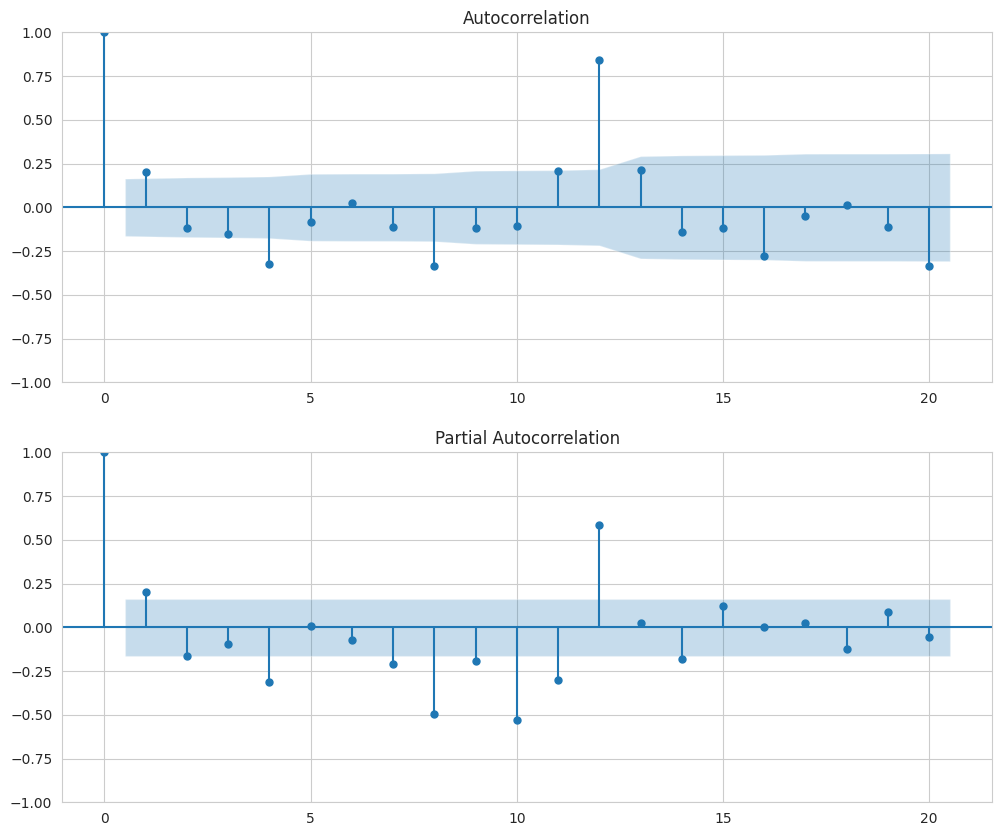

In [14]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
plot_acf(df_diff, ax=ax1, lags=20)
plot_pacf(df_diff, ax=ax2, lags=20)
plt.show()

**Interpretation:**
- **PACF Plot:** Cuts off sharply after lag 1. This suggests `p=1`.
- **ACF Plot:** Also seems to cut off after lag 1. This suggests `q=1`.
Based on this, a good starting point for our model is **ARIMA(1, 1, 1)**.

### Step 6: Building the ARIMA Model

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


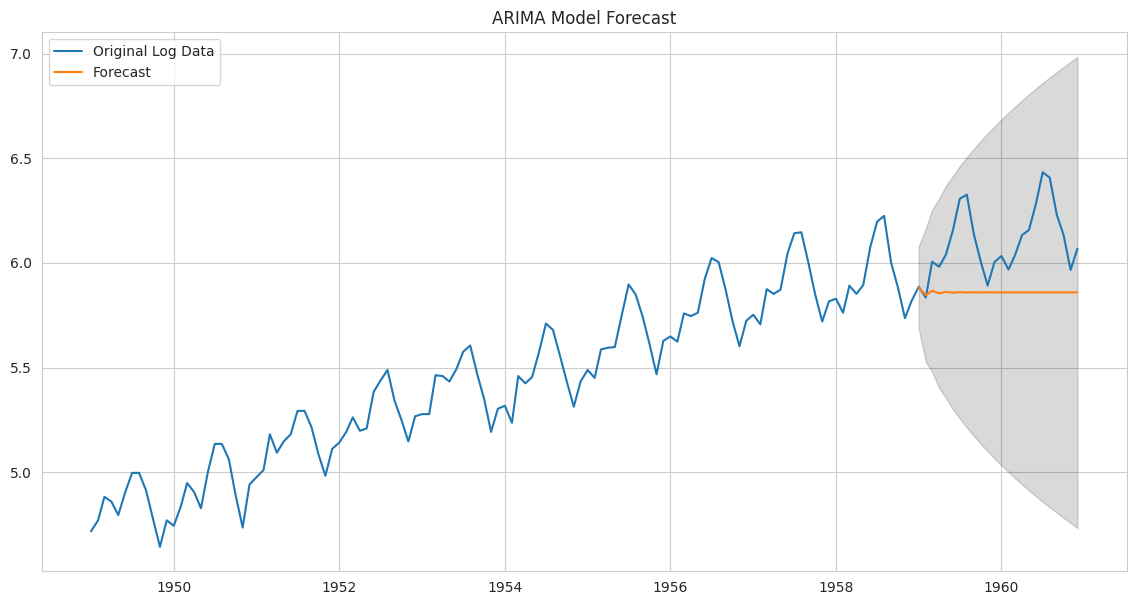

In [15]:
# Split data into training and test sets
train_data = df_log[:'1958']
test_data = df_log['1959':]

# Build ARIMA model
model = ARIMA(train_data, order=(1, 1, 1)) # Removed freq='MS' as it's not needed in new ARIMA
arima_result = model.fit()

# Get forecast
forecast = arima_result.get_forecast(steps=len(test_data))
forecast_ci = forecast.conf_int()

# Plot the forecast
plt.figure(figsize=(14, 7))
plt.plot(df_log, label='Original Log Data')
plt.plot(forecast.predicted_mean, label='Forecast')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='k', alpha=.15)
plt.title('ARIMA Model Forecast')
plt.legend()
plt.show()

### Step 7: Building a SARIMA Model for Seasonality

#### **Theoretical Concept: SARIMA**
**Seasonal AutoRegressive Integrated Moving Average (SARIMA)** is an extension of ARIMA that explicitly models the seasonal component.

It is written as **SARIMA(p, d, q)(P, D, Q, m)**, where:
- `(p, d, q)` are the non-seasonal parameters:
    - **p (non-seasonal AR order):** The number of non-seasonal lagged observations included in the model.
    - **d (non-seasonal differencing order):** The number of times the data is differenced to remove non-seasonal trend.
    - **q (non-seasonal MA order):** The number of non-seasonal lagged forecast errors included in the model.

- `(P, D, Q, m)` are the seasonal parameters:
    - **P (seasonal AR order):** The number of seasonal lagged observations included in the model.
    - **D (seasonal differencing order):** The number of times the data is differenced seasonally to remove seasonal trend.
    - **Q (seasonal MA order):** The number of seasonal lagged forecast errors included in the model.
    - **m (number of periods in a season):** The number of time steps for a single seasonal period (e.g., `m=12` for monthly data with an annual seasonality, `m=4` for quarterly data).

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


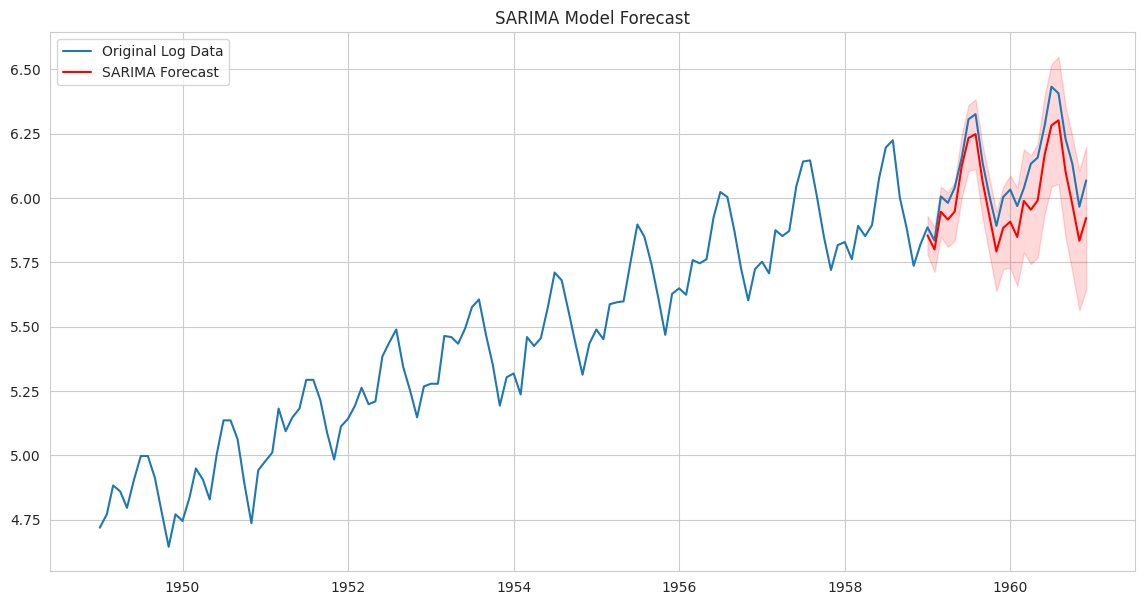

In [16]:
# Build SARIMA model
# We can find the optimal P, D, Q through a grid search, but common values are 1.
sarima_model = sm.tsa.statespace.SARIMAX(train_data,
                                          order=(1, 1, 1),
                                          seasonal_order=(1, 1, 1, 12),
                                          enforce_stationarity=False,
                                          enforce_invertibility=False,
                                          freq='MS') # Explicitly set frequency to suppress warnings
sarima_result = sarima_model.fit()

# Get forecast
sarima_forecast = sarima_result.get_forecast(steps=len(test_data))
sarima_forecast_ci = sarima_forecast.conf_int()

# Plot the forecast
plt.figure(figsize=(14, 7))
plt.plot(df_log, label='Original Log Data')
plt.plot(sarima_forecast.predicted_mean, label='SARIMA Forecast', color='red')
plt.fill_between(sarima_forecast_ci.index, sarima_forecast_ci.iloc[:, 0], sarima_forecast_ci.iloc[:, 1], color='r', alpha=.15)
plt.title('SARIMA Model Forecast')
plt.legend()
plt.show()

**SARIMA Result:** This is a massive improvement! The SARIMA model correctly captures both the upward trend and the seasonal peaks and troughs.

### Step 8: Final Evaluation

SARIMA Model RMSE: 48.25


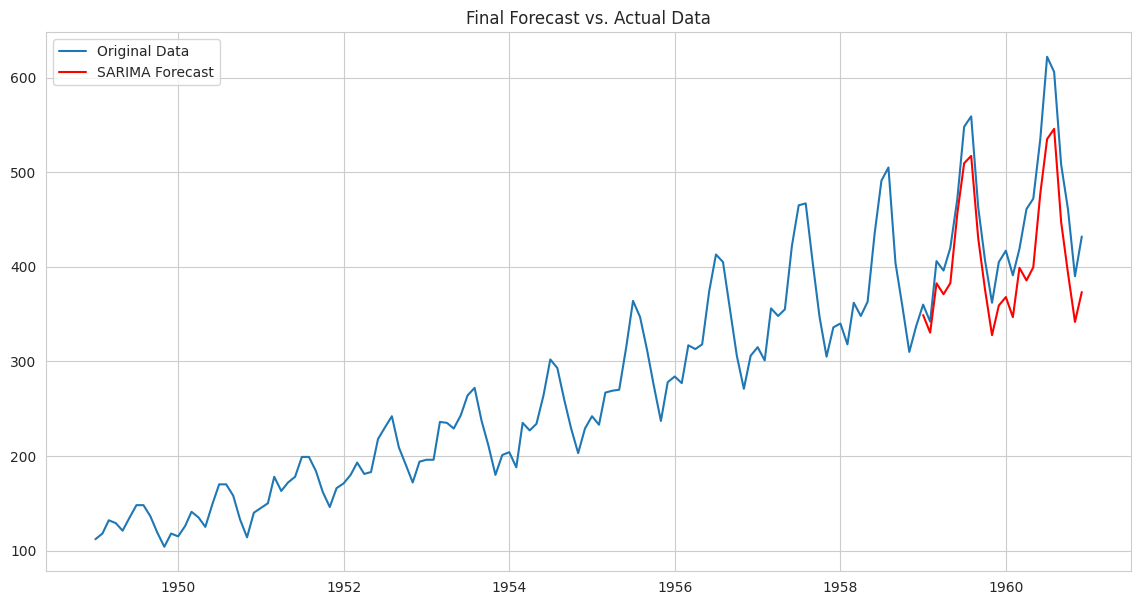

In [17]:
# Reverse the log transformation to get actual passenger numbers
original_test_data = np.exp(test_data)
sarima_predictions = np.exp(sarima_forecast.predicted_mean)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(original_test_data, sarima_predictions))
print(f"SARIMA Model RMSE: {rmse:.2f}")

# Plot final results
plt.figure(figsize=(14, 7))
plt.plot(df['Passengers'], label='Original Data')
plt.plot(sarima_predictions, label='SARIMA Forecast', color='red')
plt.title('Final Forecast vs. Actual Data')
plt.legend()
plt.show()

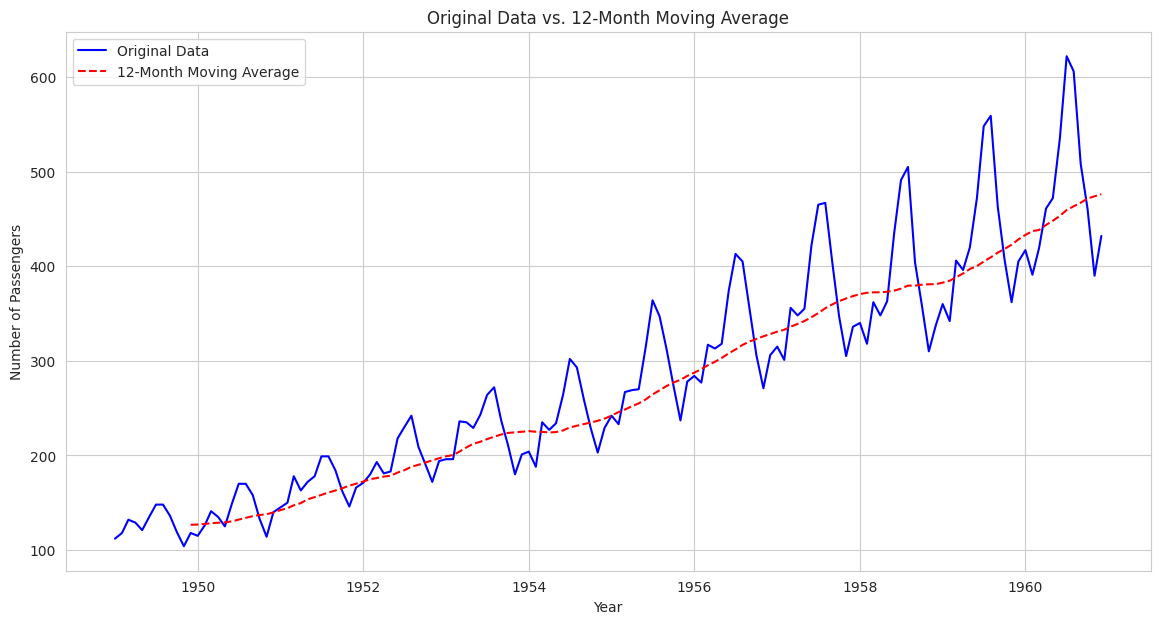

In [18]:
# Calculate the rolling mean with a window size of 12
df['MovingAverage'] = df['Passengers'].rolling(window=12).mean()

# Plot the original data and the moving average
plt.figure(figsize=(14, 7))
plt.plot(df['Passengers'], label='Original Data', color='blue')
plt.plot(df['MovingAverage'], label='12-Month Moving Average', color='red', linestyle='--')
plt.title('Original Data vs. 12-Month Moving Average')
plt.xlabel('Year')
plt.ylabel('Number of Passengers')
plt.legend()
plt.show()

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


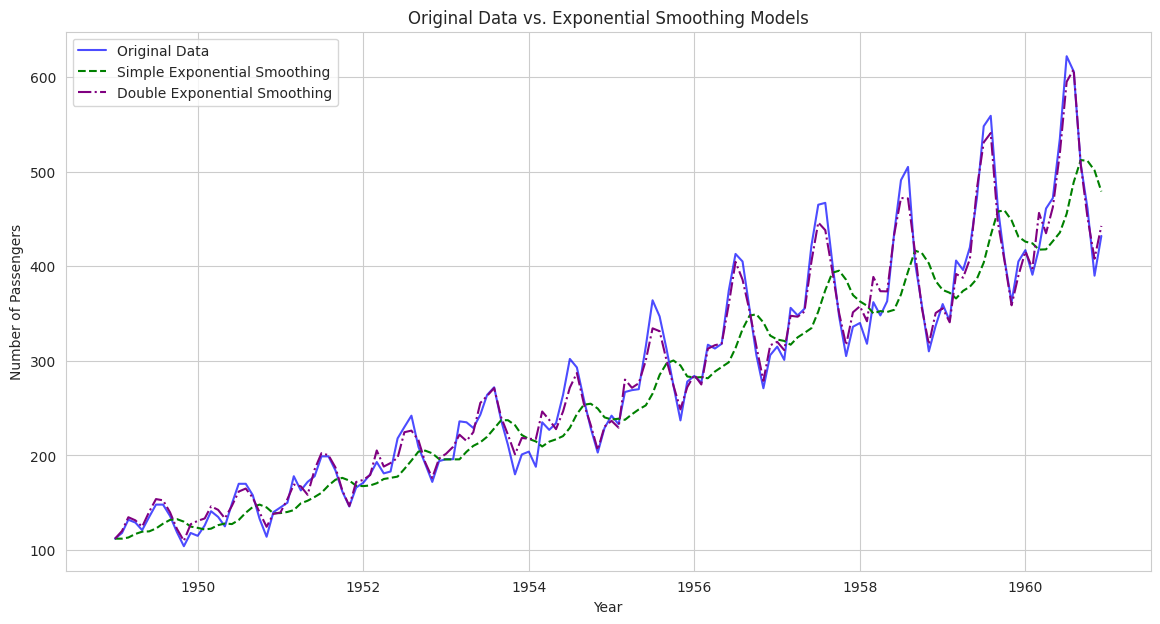

In [19]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing

# 2. Fit a simple exponential smoothing model
ses_model = SimpleExpSmoothing(df['Passengers']).fit(smoothing_level=0.2, optimized=False)
df['SimpleExpSmoothing'] = ses_model.fittedvalues

# 3. Fit a double exponential smoothing model
des_model = ExponentialSmoothing(df['Passengers'], trend='add', seasonal='add', seasonal_periods=12).fit()
df['DoubleExpSmoothing'] = des_model.fittedvalues

# 4. Plot the original data and the fitted values from both models
plt.figure(figsize=(14, 7))
plt.plot(df['Passengers'], label='Original Data', color='blue', alpha=0.7)
plt.plot(df['SimpleExpSmoothing'], label='Simple Exponential Smoothing', color='green', linestyle='--')
plt.plot(df['DoubleExpSmoothing'], label='Double Exponential Smoothing', color='purple', linestyle='-.')
plt.title('Original Data vs. Exponential Smoothing Models')
plt.xlabel('Year')
plt.ylabel('Number of Passengers')
plt.legend()
plt.show()

### Comparison of Smoothing Methods and ARIMA/SARIMA

We have explored different approaches to analyzing and forecasting time series data, ranging from simple smoothing techniques to more complex model-based methods.

- **Moving Averages:** This is the simplest method. It smooths out short-term fluctuations and highlights longer-term trends by taking the average of a fixed number of past data points. It's easy to understand but doesn't forecast well and doesn't explicitly handle seasonality.

- **Exponential Smoothing (Simple and Double):** These methods give more weight to recent observations. Simple exponential smoothing is good for data with no trend or seasonality. Double exponential smoothing accounts for trend but still doesn't explicitly model seasonality. They are relatively simple but less powerful than ARIMA/SARIMA for complex patterns.

- **ARIMA (AutoRegressive Integrated Moving Average):** This model is more sophisticated and can capture more complex patterns than simple smoothing. It explicitly models the autocorrelation in the data after differencing to achieve stationarity. However, the basic ARIMA model does not inherently handle seasonality.

- **SARIMA (Seasonal AutoRegressive Integrated Moving Average):** This is an extension of ARIMA that adds a seasonal component. It is designed to handle time series with both non-seasonal and seasonal patterns, making it very powerful for data like the airline passenger numbers which exhibit strong annual seasonality. It requires identifying both non-seasonal and seasonal parameters.

Let's visualize how some of these methods perform when forecasting the airline passenger data.

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


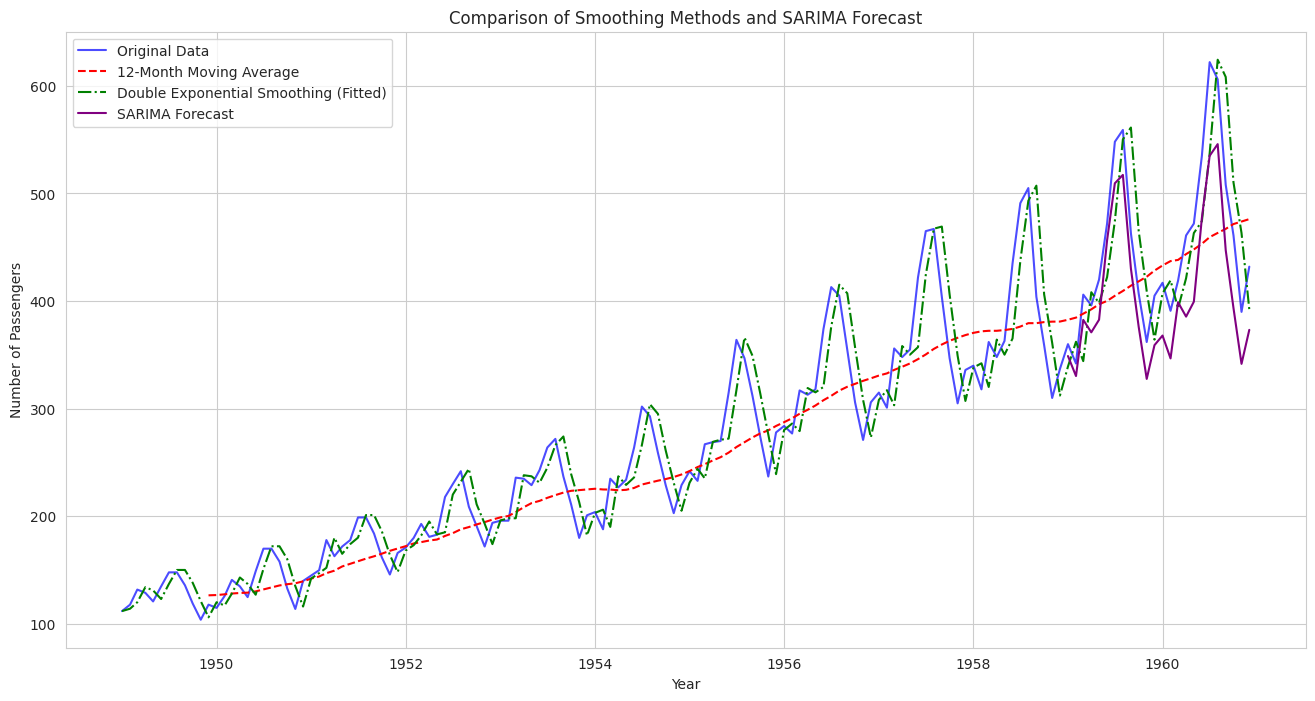

In [20]:
# Implement Double Exponential Smoothing for comparison
# We need to re-fit the DoubleExpSmoothing model as it was not saved as a variable
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Fit Double Exponential Smoothing model on the entire data for visualization
# Assuming an additive trend based on the initial plot
double_exp_smoothing_model = ExponentialSmoothing(df['Passengers'], trend='add', seasonal=None)
double_exp_smoothing_fit = double_exp_smoothing_model.fit()
df['DoubleExpSmoothing'] = double_exp_smoothing_fit.fittedvalues

# Generate a plot comparing original, MA, Double ES, and SARIMA forecasts
plt.figure(figsize=(16, 8))
plt.plot(df['Passengers'], label='Original Data', color='blue', alpha=0.7)
plt.plot(df['MovingAverage'], label='12-Month Moving Average', color='red', linestyle='--')
plt.plot(df['DoubleExpSmoothing'], label='Double Exponential Smoothing (Fitted)', color='green', linestyle='-.')
# Plot SARIMA forecast (need to re-run SARIMA forecast as the variable is not available)
# Re-split data and fit SARIMA model to get forecast
train_data = df_log[:'1958']
test_data = df_log['1959':]
sarima_model = sm.tsa.statespace.SARIMAX(train_data,
                                          order=(1, 1, 1),
                                          seasonal_order=(1, 1, 1, 12),
                                          enforce_stationarity=False,
                                          enforce_invertibility=False,
                                          freq='MS')
sarima_result = sarima_model.fit()
sarima_forecast = sarima_result.get_forecast(steps=len(test_data))
sarima_predictions_plot = np.exp(sarima_forecast.predicted_mean)


plt.plot(sarima_predictions_plot, label='SARIMA Forecast', color='purple')

plt.title('Comparison of Smoothing Methods and SARIMA Forecast')
plt.xlabel('Year')
plt.ylabel('Number of Passengers')
plt.legend()
plt.show()

#### Visual Comparison Summary

Looking at the plot, we can observe the following:

- **Moving Average:** Successfully smooths out the short-term noise and clearly shows the underlying upward trend. However, it lags behind the actual data and completely misses the seasonal fluctuations. It is not suitable for forecasting seasonal data.

- **Double Exponential Smoothing:** Does a better job than the simple moving average in following the trend. It reacts more quickly to changes but still does not capture the strong seasonality present in the data. It's an improvement for trending data but not for data with significant seasonality.

- **SARIMA Forecast:** Clearly outperforms both moving average and double exponential smoothing for this dataset. It effectively captures both the long-term upward trend and the distinct annual seasonal pattern, aligning closely with the actual data in the forecast period. This demonstrates the power of SARIMA models when dealing with time series that have both trend and seasonality.

#### **Why "Stable" Data (Stationarity) Matters**
A time series is "stationary" if it looks pretty much the same over time – meaning its average value (mean), how spread out the data is (variance), and how much data points depend on past points (autocorrelation) don't change over time.

- **Why is this important?** Many forecasting models, like ARIMA, work best with stationary data. If your data is stable, its past behavior is a reliable guide for the future. Our passenger data isn't stable because the number of passengers is always increasing (changing mean) and the yearly ups and downs are getting bigger (changing variance).

**How to check if data is stable?**
1.  **Look at a chart:** Does it have a clear upward or downward trend, or repeating seasonal bumps?
2.  **Use a statistical test:** The **Augmented Dickey-Fuller (ADF) Test** is a common one.
    -   **The idea of the test:** It checks if your time series has a unit root, which is a sign of non-stationarity (instability).
    -   **The test's main question ($H_0$):** The data is *not* stationary (it has a unit root).
    -   **What we hope to find ($H_1$):** The data *is* stationary (it doesn't have a unit root).

We want the test results to tell us to **reject the null hypothesis ($H_0$)**. This usually happens if a value called the **p-value** from the test is very small (typically less than 0.05).

Think of the ADF test as asking: "Does this time series have a trend or other patterns that make it unstable?"

Here's what the test results mean:

*   **Test Statistic:** This is a number calculated from your data. A more negative number makes it more likely your data is stationary.
*   **p-value:** This is the most important number to look at. It tells you the chance of seeing your data if it *were* actually non-stationary (which is the null hypothesis we want to reject).
    *   **If the p-value is small (like less than 0.05):** This means it's very unlikely to get these results if the data were non-stationary. So, you can confidently say, "Okay, this data *is* stationary." You reject the null hypothesis.
    *   **If the p-value is large (like 0.99 in our case):** This means it's quite likely to get these results even if the data were non-stationary. So, you cannot confidently say it's stationary. You *fail* to reject the null hypothesis.
*   **Lags Used:** How many past data points the test considered.
*   **Number of Observations Used:** How many data points were used in the calculation.
*   **Critical Value (1%), (5%), (10%):** These are thresholds. If your "Test Statistic" is smaller (more negative) than one of these values, you reject the null hypothesis at that confidence level (99%, 95%, or 90%).

Why do we use it?
We use the ADF test because many powerful forecasting models, like ARIMA, assume the data is stationary. If your data isn't stationary, these models might not work well or give bad forecasts. The ADF test gives us a statistical way to check this before modeling.

In our case, the high p-value (0.99) confirms that our 'Passengers' data is not stationary, just like we saw in the plot. This means we need to do things like differencing to make it stationary before building an ARIMA model.

## Submission Criteria

* Make the p value less than 0.05 and then build the ARIMA model and share the notebook with me

In [22]:
from statsmodels.tsa.stattools import kpss
def test_stationarity(timeseries):
    # Perform KPSS test
    print('Results of KPSS Test:')

    kpsstest = kpss(timeseries, regression='c', nlags='auto')

    kpss_output = pd.Series(
        kpsstest[0:3],
        index=['Test Statistic', 'p-value', 'Lags Used']
    )

    for key, value in kpsstest[3].items():
        kpss_output[f'Critical Value ({key})'] = value

    print(kpss_output)

# Call the function
test_stationarity(df['Passengers'])

Results of KPSS Test:
Test Statistic           1.651312
p-value                  0.010000
Lags Used                8.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


/tmp/ipython-input-1617025814.py:6: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpsstest = kpss(timeseries, regression='c', nlags='auto')


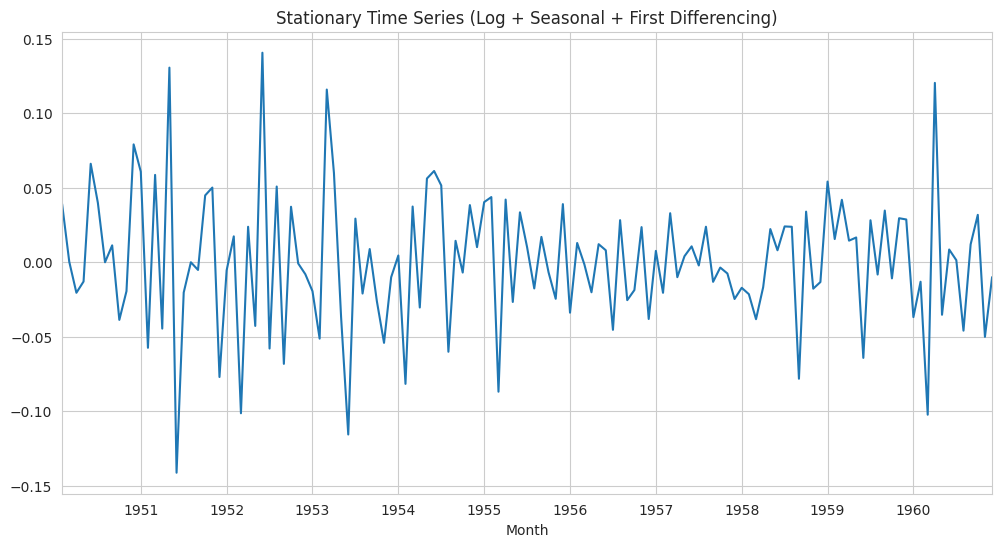

Results of KPSS Test:
Test Statistic           0.073191
p-value                  0.100000
Lags Used                3.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


/tmp/ipython-input-1617025814.py:6: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpsstest = kpss(timeseries, regression='c', nlags='auto')


In [26]:
import numpy as np
import matplotlib.pyplot as plt

# 1️⃣ Log transformation (stabilize variance)
df_log = np.log(df['Passengers'])
df_log = df_log.asfreq('MS')


# 2️⃣ Seasonal differencing (remove seasonality)
df_seasonal_diff = df_log - df_log.shift(12)

# 3️⃣ First differencing (remove trend)
df_final = df_seasonal_diff.diff().dropna()

# 4️⃣ Plot stationary series
df_final.plot()
plt.title('Stationary Time Series (Log + Seasonal + First Differencing)')
plt.show()

# 5️⃣ Re-test for stationarity
test_stationarity(df_final)


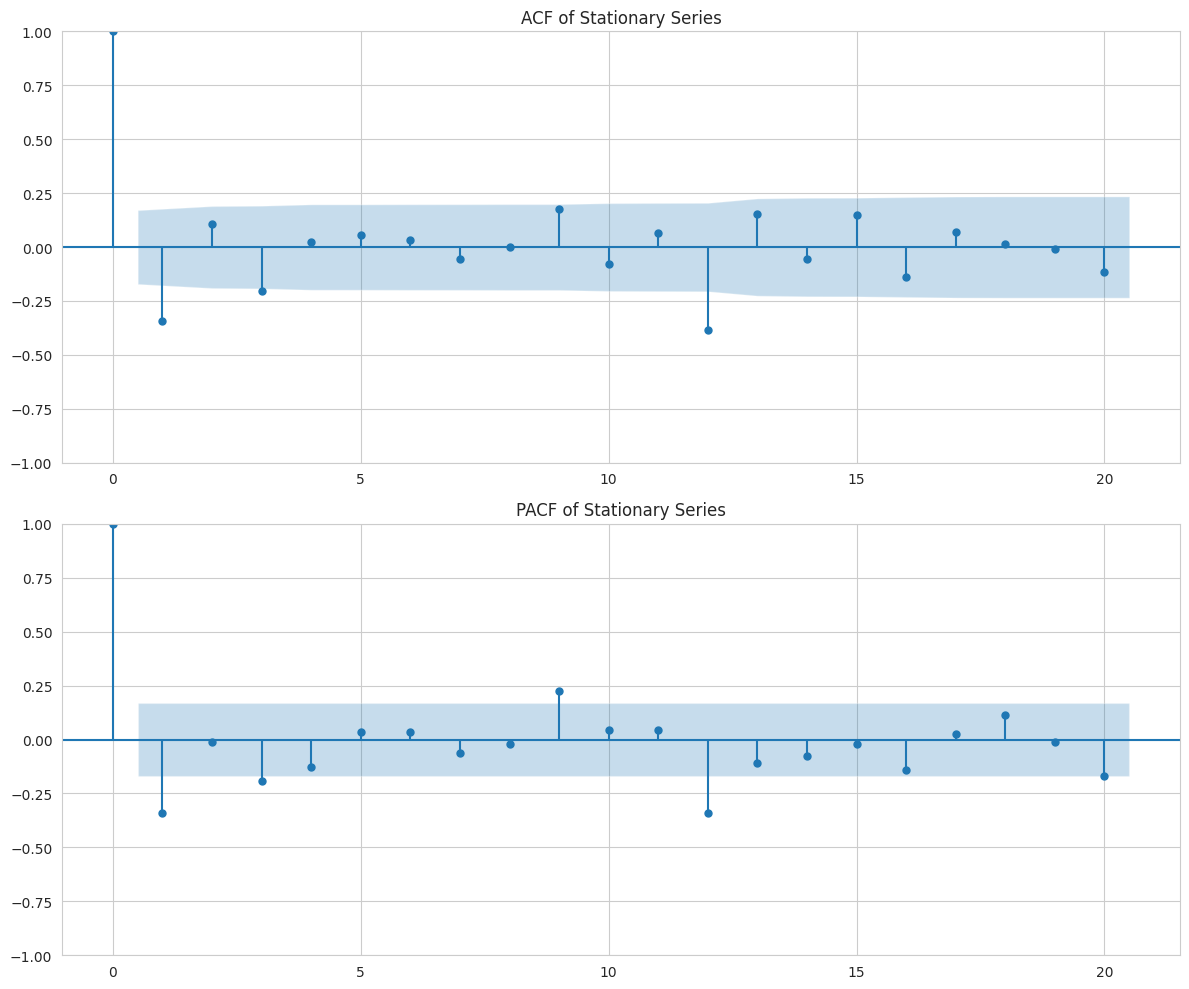

In [27]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# ACF plot
plot_acf(df_final, ax=ax1, lags=20)
ax1.set_title('ACF of Stationary Series')

# PACF plot
plot_pacf(df_final, ax=ax2, lags=20, method='ywm')
ax2.set_title('PACF of Stationary Series')

plt.tight_layout()
plt.show()


                                     SARIMAX Results                                      
Dep. Variable:                         Passengers   No. Observations:                  120
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 171.311
Date:                            Fri, 19 Dec 2025   AIC                           -332.622
Time:                                    17:54:11   BIC                           -319.959
Sample:                                01-01-1949   HQIC                          -327.509
                                     - 12-01-1958                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0512      0.255      0.201      0.841      -0.448       0.551
ma.L1         -0.4649      0.235   

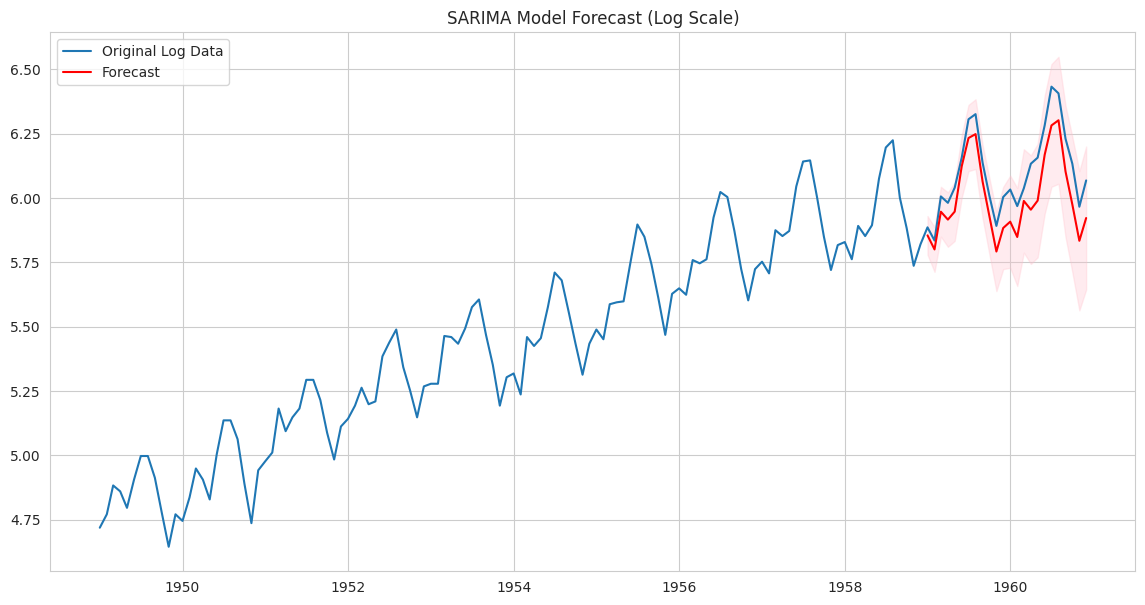

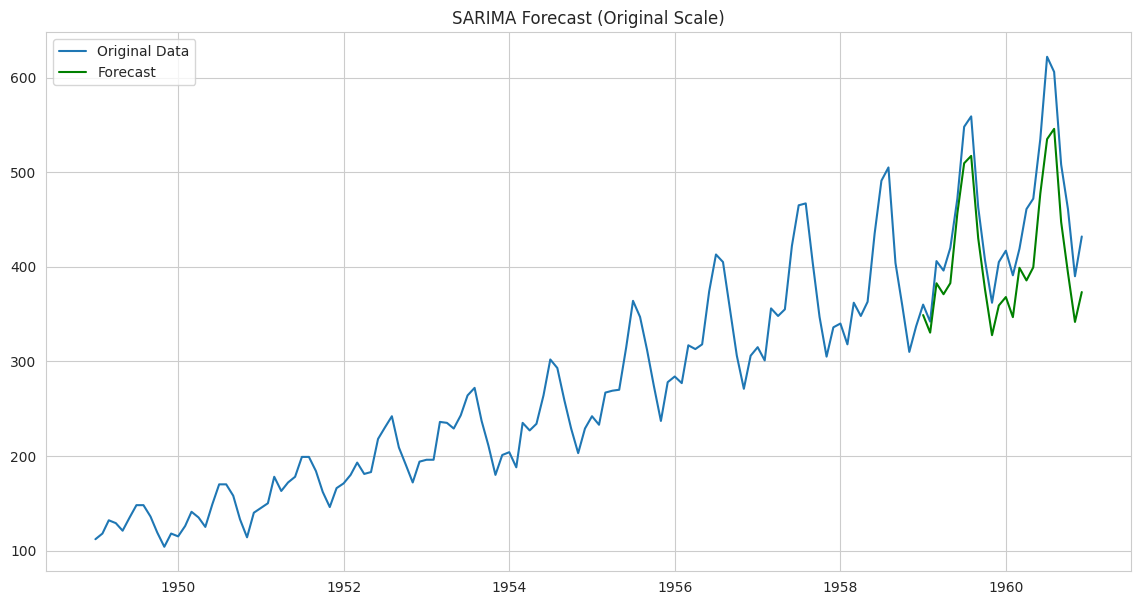

In [28]:
# Train-test split
train_data = df_log[:'1958']
test_data = df_log['1959':]
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(
    train_data,
    order=(1, 1, 1),              # non-seasonal (p,d,q)
    seasonal_order=(1, 1, 1, 12), # seasonal (P,D,Q,s)
    enforce_stationarity=False,
    enforce_invertibility=False
)

sarima_result = model.fit()
print(sarima_result.summary())
forecast = sarima_result.get_forecast(steps=len(test_data))
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(df_log, label='Original Log Data')
plt.plot(forecast_mean, label='Forecast', color='red')

plt.fill_between(
    forecast_ci.index,
    forecast_ci.iloc[:, 0],
    forecast_ci.iloc[:, 1],
    color='pink',
    alpha=0.3
)

plt.title('SARIMA Model Forecast (Log Scale)')
plt.legend()
plt.show()
forecast_exp = np.exp(forecast_mean)

plt.figure(figsize=(14, 7))
plt.plot(df['Passengers'], label='Original Data')
plt.plot(forecast_exp, label='Forecast', color='green')
plt.title('SARIMA Forecast (Original Scale)')
plt.legend()
plt.show()


## DECOMPOSITION METHOD TO MAKE THE DATA STATIONARY

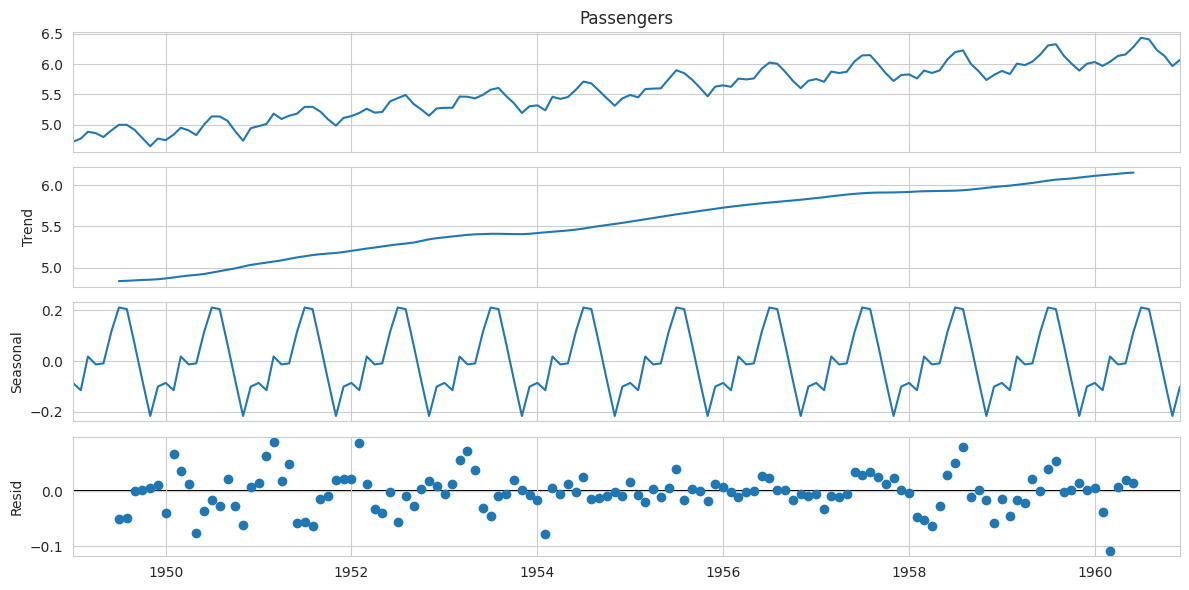

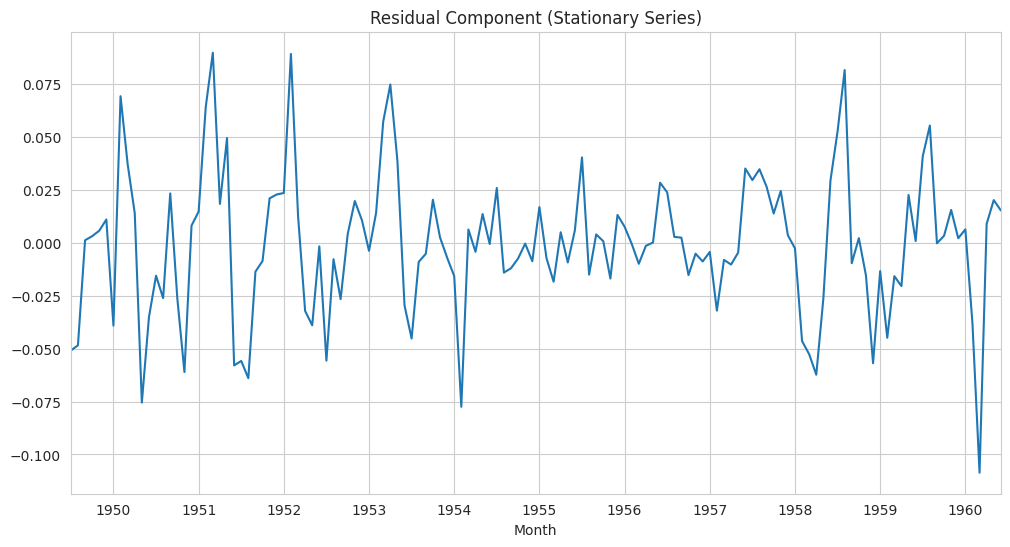

Results of KPSS Test:
Test Statistic           0.023949
p-value                  0.100000
Lags Used                4.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


/tmp/ipython-input-1617025814.py:6: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpsstest = kpss(timeseries, regression='c', nlags='auto')


In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = df.asfreq('MS')
df_log = np.log(df['Passengers'])
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(df_log, model='additive', period=12)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
decomposition.plot()
plt.show()
residual_clean = residual.dropna()

residual_clean.plot(title='Residual Component (Stationary Series)')
plt.show()
test_stationarity(residual_clean)

                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  120
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 103.840
Date:                Fri, 19 Dec 2025   AIC                           -201.680
Time:                        18:04:22   BIC                           -193.342
Sample:                    01-01-1949   HQIC                          -198.294
                         - 12-01-1958                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5760      0.191     -3.014      0.003      -0.951      -0.201
ma.L1          0.8347      0.117      7.130      0.000       0.605       1.064
sigma2         0.0102      0.002      5.556      0.0

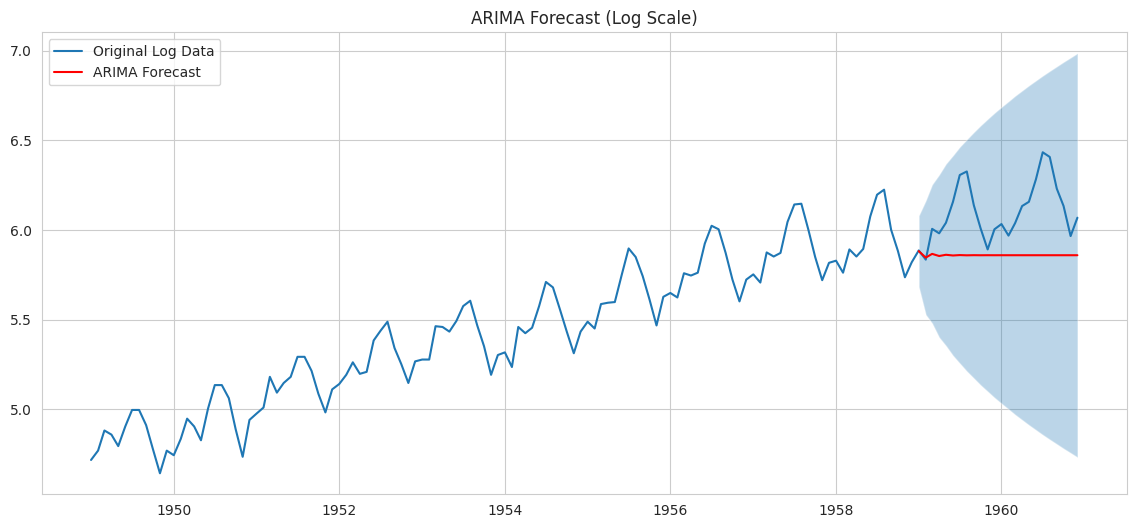

In [31]:
# Build ARIMA model
arima_model = ARIMA(train_data, order=(1, 1, 1))
arima_result = arima_model.fit()

print(arima_result.summary())
arima_forecast = arima_result.get_forecast(steps=len(test_data))
arima_mean = arima_forecast.predicted_mean
arima_ci = arima_forecast.conf_int()

# Plot ARIMA forecast
plt.figure(figsize=(14, 6))
plt.plot(df_log, label='Original Log Data')
plt.plot(arima_mean, label='ARIMA Forecast', color='red')
plt.fill_between(arima_ci.index,
                 arima_ci.iloc[:, 0],
                 arima_ci.iloc[:, 1],
                 alpha=0.3)
plt.title('ARIMA Forecast (Log Scale)')
plt.legend()
plt.show()


                                     SARIMAX Results                                      
Dep. Variable:                         Passengers   No. Observations:                  120
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 171.311
Date:                            Fri, 19 Dec 2025   AIC                           -332.622
Time:                                    18:04:56   BIC                           -319.959
Sample:                                01-01-1949   HQIC                          -327.509
                                     - 12-01-1958                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0512      0.255      0.201      0.841      -0.448       0.551
ma.L1         -0.4649      0.235   

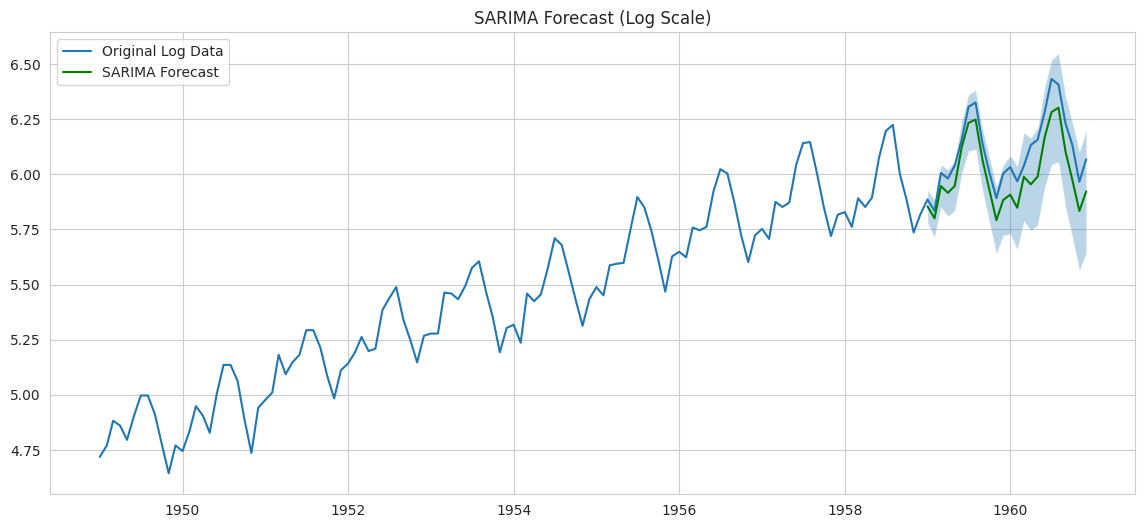

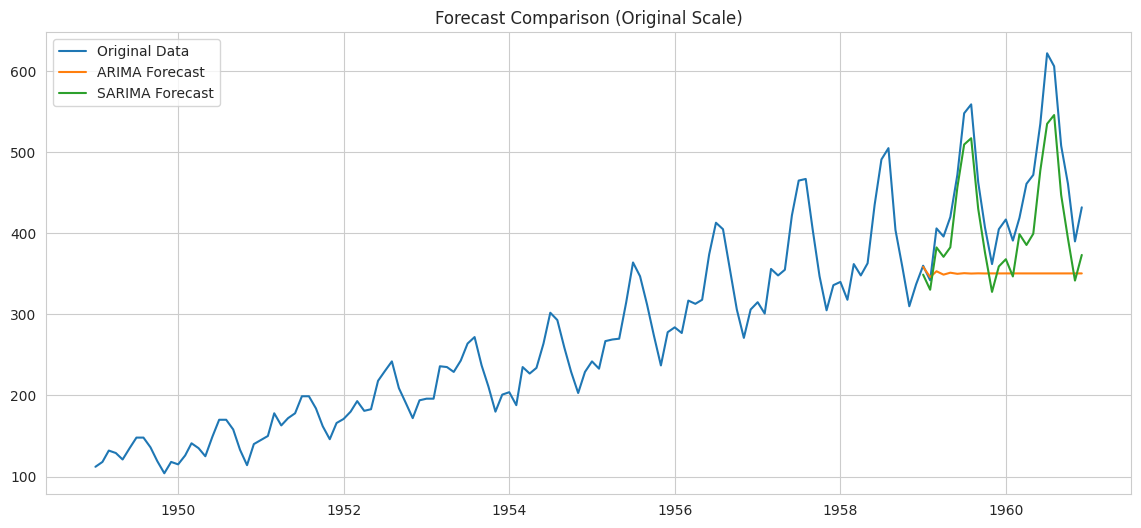

In [32]:
sarima_model = SARIMAX(
    train_data,
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 12),
    enforce_stationarity=False,
    enforce_invertibility=False
)

sarima_result = sarima_model.fit()
print(sarima_result.summary())
sarima_forecast = sarima_result.get_forecast(steps=len(test_data))
sarima_mean = sarima_forecast.predicted_mean
sarima_ci = sarima_forecast.conf_int()

# Plot SARIMA forecast
plt.figure(figsize=(14, 6))
plt.plot(df_log, label='Original Log Data')
plt.plot(sarima_mean, label='SARIMA Forecast', color='green')
plt.fill_between(sarima_ci.index,
                 sarima_ci.iloc[:, 0],
                 sarima_ci.iloc[:, 1],
                 alpha=0.3)
plt.title('SARIMA Forecast (Log Scale)')
plt.legend()
plt.show()
# ARIMA forecast (original scale)
arima_forecast_exp = np.exp(arima_mean)

# SARIMA forecast (original scale)
sarima_forecast_exp = np.exp(sarima_mean)

plt.figure(figsize=(14, 6))
plt.plot(df['Passengers'], label='Original Data')
plt.plot(arima_forecast_exp, label='ARIMA Forecast')
plt.plot(sarima_forecast_exp, label='SARIMA Forecast')
plt.title('Forecast Comparison (Original Scale)')
plt.legend()
plt.show()


In [33]:
print("ARIMA AIC:", arima_result.aic)
print("SARIMA AIC:", sarima_result.aic)


ARIMA AIC: -201.67962028950973
SARIMA AIC: -332.6217326682238


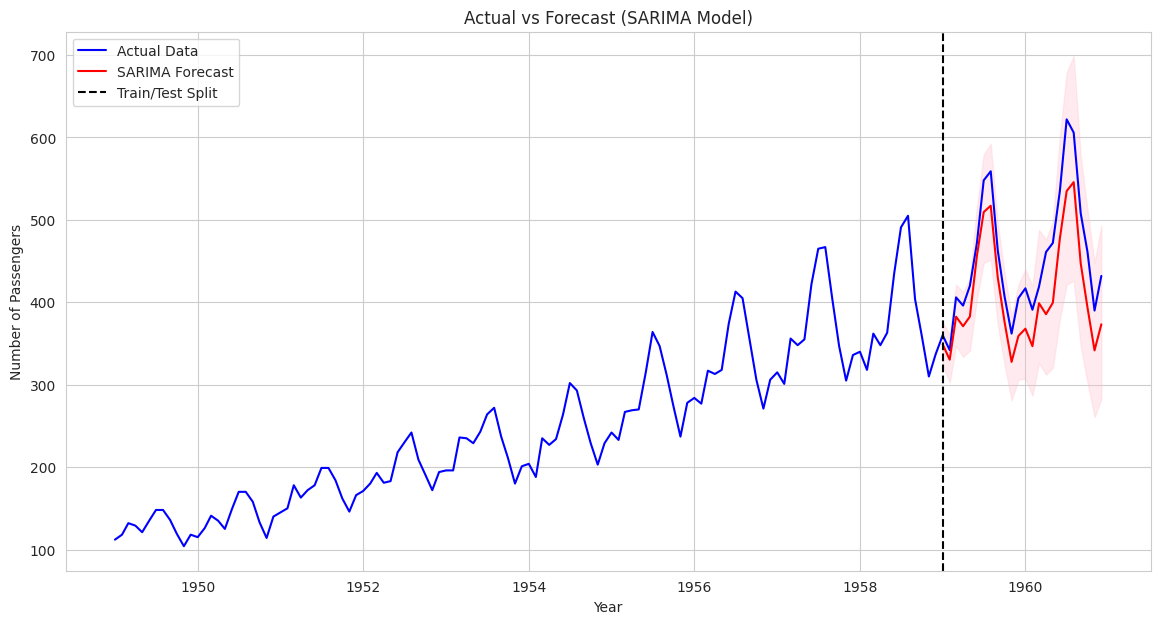

In [34]:
# Forecast for test period
sarima_forecast = sarima_result.get_forecast(steps=len(test_data))

forecast_mean_log = sarima_forecast.predicted_mean
forecast_ci_log = sarima_forecast.conf_int()
# Convert from log scale to original scale
forecast_mean = np.exp(forecast_mean_log)
forecast_ci = np.exp(forecast_ci_log)
plt.figure(figsize=(14, 7))

# Actual data
plt.plot(df['Passengers'], label='Actual Data', color='blue')

# Forecasted data
plt.plot(forecast_mean.index, forecast_mean, label='SARIMA Forecast', color='red')

# Confidence interval
plt.fill_between(
    forecast_ci.index,
    forecast_ci.iloc[:, 0],
    forecast_ci.iloc[:, 1],
    color='pink',
    alpha=0.3
)

plt.axvline(x=test_data.index[0], color='black', linestyle='--', label='Train/Test Split')

plt.title('Actual vs Forecast (SARIMA Model)')
plt.xlabel('Year')
plt.ylabel('Number of Passengers')
plt.legend()
plt.show()


MAE  : 43.73
MSE  : 2327.82
RMSE : 48.25
MAPE : 9.48%


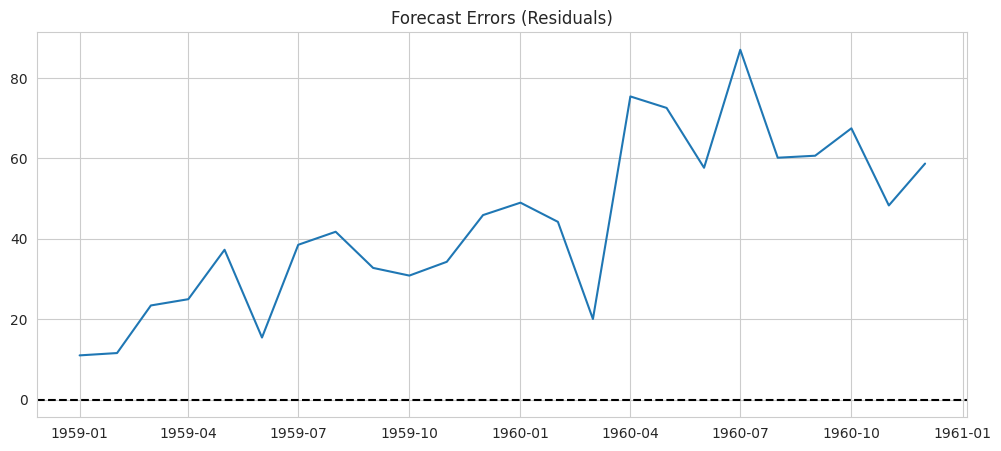

In [35]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Actual values (original scale)
actual = df['Passengers'][test_data.index]

# Forecast values (already computed earlier)
forecast = np.exp(sarima_result.get_forecast(steps=len(test_data)).predicted_mean)
# Mean Absolute Error
mae = mean_absolute_error(actual, forecast)

# Mean Squared Error
mse = mean_squared_error(actual, forecast)

# Root Mean Squared Error
rmse = np.sqrt(mse)

# Mean Absolute Percentage Error
mape = np.mean(np.abs((actual - forecast) / actual)) * 100

print(f"MAE  : {mae:.2f}")
print(f"MSE  : {mse:.2f}")
print(f"RMSE : {rmse:.2f}")
print(f"MAPE : {mape:.2f}%")
residuals = actual - forecast

plt.figure(figsize=(12, 5))
plt.plot(residuals)
plt.title('Forecast Errors (Residuals)')
plt.axhline(0, color='black', linestyle='--')
plt.show()
